In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "CS231n/assignment1"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CS231n/assignment1/cs231n/datasets
/content/drive/My Drive/CS231n/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


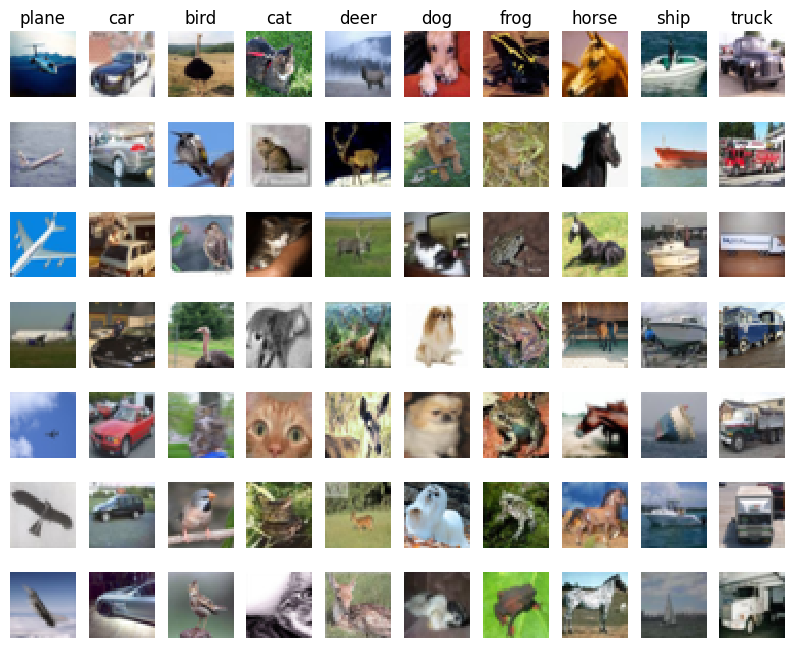

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


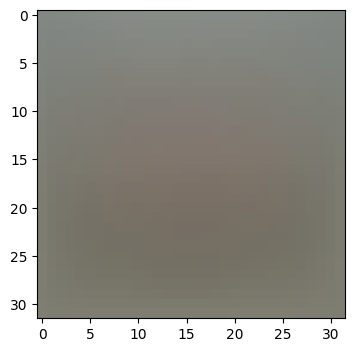

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.981657


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -10.773374 analytic: -10.773374, relative error: 9.669621e-13
numerical: 14.491790 analytic: 14.566698, relative error: 2.577853e-03
numerical: -9.350414 analytic: -9.350414, relative error: 1.593626e-11
numerical: -9.878960 analytic: -9.878960, relative error: 2.238751e-11
numerical: 16.576912 analytic: 16.619422, relative error: 1.280558e-03
numerical: 7.182905 analytic: 7.182905, relative error: 1.439677e-11
numerical: 34.700252 analytic: 34.700252, relative error: 9.150270e-12
numerical: 5.148315 analytic: 5.148315, relative error: 3.119217e-12
numerical: 9.017168 analytic: 9.017168, relative error: 1.741967e-11
numerical: 4.147772 analytic: 4.147772, relative error: 5.728498e-11
numerical: 7.549726 analytic: 7.622739, relative error: 4.812201e-03
numerical: 2.747439 analytic: 2.747439, relative error: 9.679501e-11
numerical: 19.408115 analytic: 19.408115, relative error: 1.775614e-12
numerical: -12.966998 analytic: -12.966998, relative error: 3.612559e-11
numerical: -6.

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$   \
구간 [x, x+h] 안에 미분 불가능한 첨점이 존재할 때 numerical 방식으로 계산한 gradient가 잘못될 가능성이 있다.
실제로는 analytic 방식으로 계산한 값을 쓰기 때문에 결과에 지장은 없다.


In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.981657e+00 computed in 0.116790s
Vectorized loss: 8.981657e+00 computed in 0.013461s
difference: 0.000000


In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.116537s
Vectorized loss and gradient: computed in 0.013315s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

Training:   1%|          | 10/1500 [00:00<00:15, 97.44it/s]

iteration 0 / 1500: loss 19.946856


Training:   7%|▋         | 109/1500 [00:01<00:13, 105.08it/s]

iteration 100 / 1500: loss 9.108298


Training:  15%|█▍        | 222/1500 [00:02<00:11, 115.32it/s]

iteration 200 / 1500: loss 5.371568


Training:  21%|██▏       | 322/1500 [00:02<00:10, 112.28it/s]

iteration 300 / 1500: loss 4.919596


Training:  28%|██▊       | 413/1500 [00:03<00:09, 112.59it/s]

iteration 400 / 1500: loss 4.910211


Training:  34%|███▍      | 515/1500 [00:04<00:09, 107.69it/s]

iteration 500 / 1500: loss 4.612479


Training:  41%|████      | 616/1500 [00:05<00:07, 112.94it/s]

iteration 600 / 1500: loss 5.020003


Training:  48%|████▊     | 717/1500 [00:06<00:06, 115.90it/s]

iteration 700 / 1500: loss 5.006683


Training:  55%|█████▍    | 821/1500 [00:07<00:05, 120.11it/s]

iteration 800 / 1500: loss 4.802550


Training:  61%|██████    | 913/1500 [00:07<00:05, 110.87it/s]

iteration 900 / 1500: loss 5.077931


Training:  68%|██████▊   | 1022/1500 [00:08<00:04, 109.25it/s]

iteration 1000 / 1500: loss 4.971498


Training:  74%|███████▍  | 1112/1500 [00:10<00:06, 57.70it/s]

iteration 1100 / 1500: loss 4.687598


Training:  81%|████████  | 1208/1500 [00:12<00:05, 58.08it/s]

iteration 1200 / 1500: loss 5.427751


Training:  87%|████████▋ | 1312/1500 [00:13<00:03, 61.92it/s]

iteration 1300 / 1500: loss 5.047858


Training:  94%|█████████▍| 1415/1500 [00:14<00:00, 110.48it/s]

iteration 1400 / 1500: loss 4.806563


Training: 100%|██████████| 1500/1500 [00:15<00:00, 96.48it/s] 

That took 15.562866s


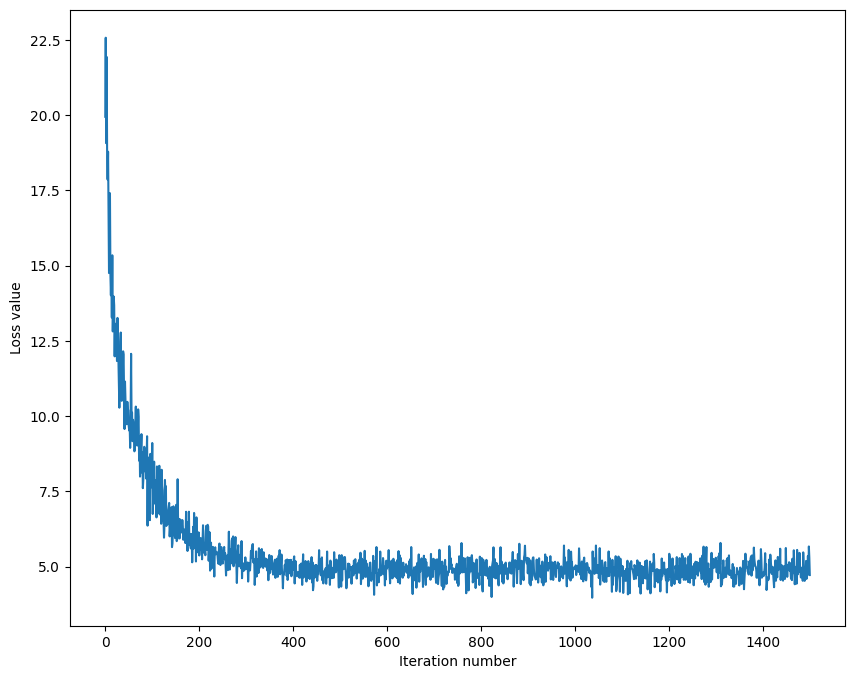

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369612
validation accuracy: 0.377000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results: dict[tuple, tuple] = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# learning_rates = [1e-7, 5e-5]
learning_rates = [5e-7, 1e-7, 5e-8]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def acc(y_pred, y_true) -> float:
    assert y_pred.shape == y_true.shape, f"{y_pred.shape} != {y_true.shape}"
    return (y_pred == y_true).sum() / y_true.size

for lr in learning_rates:
    for reg in regularization_strengths:
        classifier = LinearSVM()
        loss_hist = classifier.train(
            X_train, y_train,
            learning_rate=lr, reg=reg,
            num_iters=1000, batch_size=200,
            verbose=True,
        )

        train_pred = classifier.predict(X_train)
        train_acc = acc(train_pred, y_train)
        val_pred = classifier.predict(X_val)
        val_acc = acc(val_pred, y_val)

        results[(lr, reg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_svm = classifier


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

Training:   0%|          | 5/1000 [00:00<00:20, 48.52it/s]

iteration 0 / 1000: loss 26.490493


Training:  12%|█▏        | 118/1000 [00:01<00:08, 107.11it/s]

iteration 100 / 1000: loss 5.539637


Training:  22%|██▏       | 218/1000 [00:02<00:06, 117.58it/s]

iteration 200 / 1000: loss 5.123740


Training:  32%|███▏      | 316/1000 [00:03<00:06, 106.16it/s]

iteration 300 / 1000: loss 4.828225


Training:  41%|████      | 412/1000 [00:04<00:05, 100.17it/s]

iteration 400 / 1000: loss 5.234388


Training:  51%|█████     | 509/1000 [00:05<00:08, 60.27it/s]

iteration 500 / 1000: loss 4.930807


Training:  61%|██████    | 607/1000 [00:07<00:06, 57.10it/s]

iteration 600 / 1000: loss 5.056339


Training:  71%|███████   | 709/1000 [00:08<00:04, 63.05it/s]

iteration 700 / 1000: loss 5.493706


Training:  82%|████████▏ | 817/1000 [00:10<00:01, 115.25it/s]

iteration 800 / 1000: loss 4.550020


Training:  92%|█████████▏| 917/1000 [00:10<00:00, 113.41it/s]

iteration 900 / 1000: loss 4.969881


Training:   2%|▏         | 22/1000 [00:00<00:09, 106.61it/s]

iteration 0 / 1000: loss 21.646265


Training:  12%|█▏        | 117/1000 [00:01<00:08, 108.48it/s]

iteration 100 / 1000: loss 5.055718


Training:  21%|██▏       | 214/1000 [00:01<00:07, 109.46it/s]

iteration 200 / 1000: loss 5.489420


Training:  32%|███▏      | 321/1000 [00:02<00:06, 108.43it/s]

iteration 300 / 1000: loss 5.585119


Training:  42%|████▏     | 417/1000 [00:03<00:05, 113.33it/s]

iteration 400 / 1000: loss 5.400114


Training:  51%|█████▏    | 514/1000 [00:04<00:04, 109.80it/s]

iteration 500 / 1000: loss 5.660175


Training:  61%|██████▏   | 613/1000 [00:05<00:03, 108.79it/s]

iteration 600 / 1000: loss 5.095117


Training:  72%|███████▎  | 725/1000 [00:06<00:02, 119.04it/s]

iteration 700 / 1000: loss 5.447642


Training:  81%|████████  | 807/1000 [00:07<00:02, 74.67it/s]

iteration 800 / 1000: loss 5.923149


Training:  91%|█████████ | 908/1000 [00:09<00:01, 54.47it/s]

iteration 900 / 1000: loss 5.797139


Training:   1%|▏         | 13/1000 [00:00<00:16, 61.44it/s]

iteration 0 / 1000: loss 20.954957


Training:  12%|█▏        | 115/1000 [00:01<00:08, 108.61it/s]

iteration 100 / 1000: loss 7.174288


Training:  22%|██▏       | 220/1000 [00:02<00:07, 104.45it/s]

iteration 200 / 1000: loss 4.922388


Training:  32%|███▏      | 317/1000 [00:03<00:06, 97.77it/s]

iteration 300 / 1000: loss 5.147447


Training:  41%|████▏     | 413/1000 [00:04<00:05, 104.44it/s]

iteration 400 / 1000: loss 5.477258


Training:  51%|█████     | 509/1000 [00:04<00:04, 108.98it/s]

iteration 500 / 1000: loss 4.652869


Training:  61%|██████▏   | 614/1000 [00:05<00:03, 112.25it/s]

iteration 600 / 1000: loss 4.734973


Training:  72%|███████▏  | 720/1000 [00:06<00:02, 112.84it/s]

iteration 700 / 1000: loss 4.531865


Training:  82%|████████▏ | 819/1000 [00:07<00:01, 114.36it/s]

iteration 800 / 1000: loss 5.115525


Training:  92%|█████████▏| 919/1000 [00:08<00:00, 115.32it/s]

iteration 900 / 1000: loss 5.052736


Training:   2%|▏         | 19/1000 [00:00<00:10, 94.16it/s]

iteration 0 / 1000: loss 23.271393


Training:  11%|█         | 107/1000 [00:01<00:14, 63.16it/s]

iteration 100 / 1000: loss 6.351314


Training:  21%|██        | 210/1000 [00:03<00:13, 56.53it/s]

iteration 200 / 1000: loss 4.709946


Training:  31%|███       | 312/1000 [00:04<00:11, 58.85it/s]

iteration 300 / 1000: loss 4.923409


Training:  42%|████▏     | 418/1000 [00:06<00:06, 91.39it/s]

iteration 400 / 1000: loss 5.158571


Training:  52%|█████▏    | 524/1000 [00:07<00:04, 113.88it/s]

iteration 500 / 1000: loss 5.705462


Training:  62%|██████▏   | 616/1000 [00:08<00:03, 100.03it/s]

iteration 600 / 1000: loss 5.532634


Training:  72%|███████▏  | 719/1000 [00:09<00:02, 104.21it/s]

iteration 700 / 1000: loss 4.906080


Training:  82%|████████▏ | 820/1000 [00:10<00:01, 101.98it/s]

iteration 800 / 1000: loss 5.402537


Training:  91%|█████████▏| 913/1000 [00:11<00:00, 105.58it/s]

iteration 900 / 1000: loss 4.777056


Training:   2%|▏         | 22/1000 [00:00<00:09, 108.14it/s]

iteration 0 / 1000: loss 19.018727


Training:  12%|█▏        | 116/1000 [00:01<00:08, 107.55it/s]

iteration 100 / 1000: loss 9.766566


Training:  22%|██▏       | 220/1000 [00:02<00:07, 108.17it/s]

iteration 200 / 1000: loss 7.973858


Training:  31%|███▏      | 314/1000 [00:03<00:06, 103.45it/s]

iteration 300 / 1000: loss 6.345623


Training:  41%|████      | 408/1000 [00:04<00:09, 63.85it/s]

iteration 400 / 1000: loss 6.393439


Training:  51%|█████     | 512/1000 [00:05<00:08, 58.60it/s]

iteration 500 / 1000: loss 5.541981


Training:  61%|██████    | 608/1000 [00:07<00:06, 59.21it/s]

iteration 600 / 1000: loss 4.972701


Training:  72%|███████▏  | 715/1000 [00:09<00:03, 87.52it/s]

iteration 700 / 1000: loss 4.644040


Training:  82%|████████▏ | 821/1000 [00:09<00:01, 108.35it/s]

iteration 800 / 1000: loss 4.659756


Training:  92%|█████████▏| 917/1000 [00:10<00:00, 95.27it/s]

iteration 900 / 1000: loss 4.887440


Training:   2%|▏         | 23/1000 [00:00<00:08, 112.26it/s]

iteration 0 / 1000: loss 23.081392


Training:  12%|█▏        | 120/1000 [00:01<00:07, 110.50it/s]

iteration 100 / 1000: loss 8.327155


Training:  22%|██▏       | 217/1000 [00:01<00:07, 108.53it/s]

iteration 200 / 1000: loss 6.731702


Training:  32%|███▏      | 320/1000 [00:02<00:06, 110.15it/s]

iteration 300 / 1000: loss 5.270854


Training:  41%|████      | 410/1000 [00:03<00:05, 111.04it/s]

iteration 400 / 1000: loss 5.213677


Training:  51%|█████▏    | 513/1000 [00:04<00:04, 109.61it/s]

iteration 500 / 1000: loss 5.654218


Training:  62%|██████▏   | 616/1000 [00:05<00:03, 114.46it/s]

iteration 600 / 1000: loss 4.923624


Training:  72%|███████▏  | 718/1000 [00:06<00:02, 116.75it/s]

iteration 700 / 1000: loss 5.225980


Training:  81%|████████  | 808/1000 [00:08<00:04, 43.57it/s]

iteration 800 / 1000: loss 5.190444


Training:  90%|█████████ | 902/1000 [00:10<00:02, 35.30it/s]

iteration 900 / 1000: loss 5.195962


Training: 100%|██████████| 1000/1000 [00:12<00:00, 80.96it/s]


lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.367469 val accuracy: 0.391000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.356041 val accuracy: 0.370000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.367653 val accuracy: 0.381000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.356163 val accuracy: 0.363000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.340000 val accuracy: 0.346000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.282816 val accuracy: 0.272000
best validation accuracy achieved during cross-validation: 0.391000


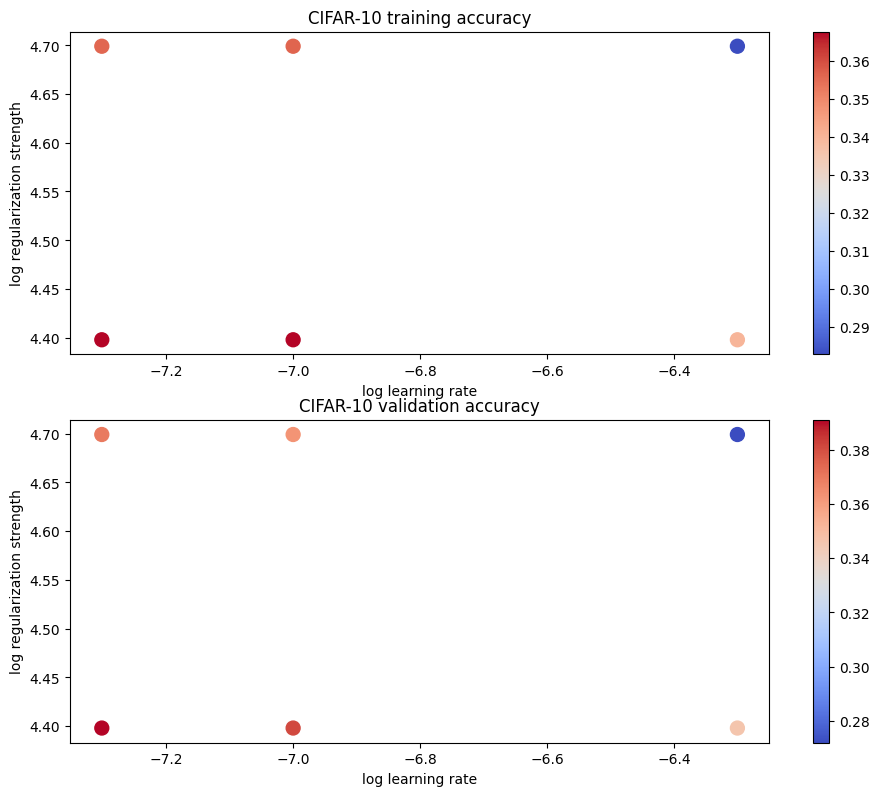

In [ ]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.361000


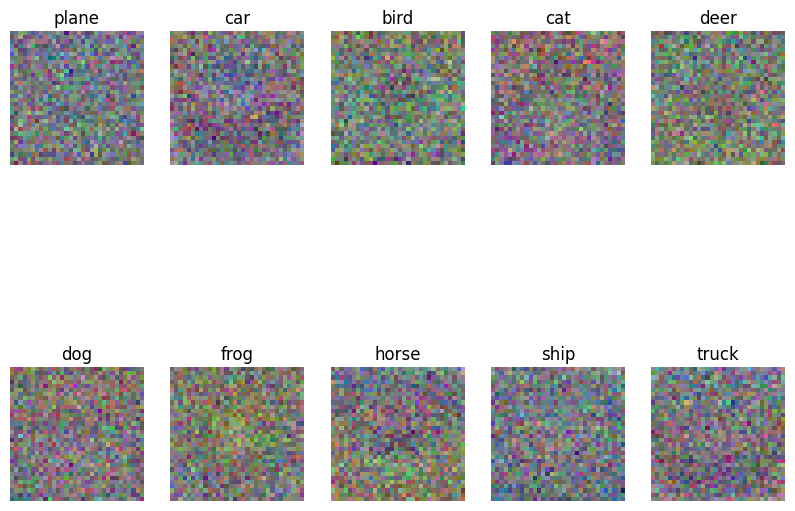

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
